[![Abrir en Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/juliopez/Taller-Fundamentos-Data-Science-Python/blob/main/03_Notebooks/05_Sesion_05.ipynb)

<img src=https://upload.wikimedia.org/wikipedia/commons/1/19/UDLA-logo-oficial.jpg width=400/>

# Fundamentos de Data Science con Python
**Dr. Julio Lopez-Nunez (2025)**

## **Sesión 5 – Clasificación de imágenes con MobileNetV2 (Transfer Learning)**  
**Duración total estimada:** 120 min  

## ⏱️ Objetivos (15 min)

### Objetivos de la actividad

- Aplicar el concepto de **Transfer Learning** usando MobileNetV2 preentrenado.
- Observar cómo un modelo preentrenado clasifica imágenes cotidianas.
- Identificar **aciertos**, **errores** y posibles **sesgos** del modelo.
- Conectar la experiencia práctica con los conceptos de **ética, sesgos e integridad en IA**.




## ⏱️ Introducción:

En esta práctica vamos a:

- Usar **MobileNetV2**, un modelo de visión por computadora ya entrenado en millones de imágenes (ImageNet).
- Clasificar imágenes reales podrán subir desde su computador.
- Analizar **aciertos y errores** del modelo.
- Reflexionar sobre posibles **sesgos** y limitaciones del modelo, conectando con lo visto en la teoría.

> Recordatorio: *un modelo puede ser muy preciso en promedio, pero profundamente injusto en casos específicos.*

---

### 1. ¿Por qué las CNN son mejores que un MLP para imágenes?

- Un MLP **no reconoce patrones espaciales** (solo recibe un vector plano).
- Una CNN sí puede analizar una imagen en pequeñas regiones.
- Detecta patrones locales como **bordes, líneas, texturas y formas**.
- Las primeras capas ven patrones simples; las profundas, patrones complejos.

---

### 2. Convolución (filtros)

- Un *filtro* (3×3 o 5×5) se desplaza sobre la imagen.
- Cada filtro aprende a detectar un tipo de patrón.
- Produce un **mapa de características** (*feature map*).

La convolución es el “ojo” de la red.

---

### 3. Pooling

- Toma un bloque pequeño (por ejemplo, 2×2) y selecciona un valor (max/avg).
- Reduce el tamaño de los mapas.
- Aumenta eficiencia y robustez al ruido.

El pooling es un “resumen” de las características detectadas.

---

### 4. Transfer Learning

- En vez de entrenar desde cero, usamos un modelo ya entrenado
  en millones de imágenes (ImageNet).
- Reutilizamos sus primeras capas (que ya saben detectar características generales).
- Solo entrenamos o usamos la capa final.

*No comenzamos de cero: aprovechamos conocimiento previo.*

---

### 5. Ética, sesgos e integridad

- Los modelos pueden contener **sesgos** por los datos con los que fueron entrenados.
- Un modelo puede ser preciso en promedio pero fallar en casos específicos.
- Por eso debemos observar:
  - Aciertos  
  - Errores  
  - Posibles sesgos  
  - Limitaciones  
- Y actuar siempre con criterio académico y ético.

---

### ¿Qué haremos ahora?

Usaremos **MobileNetV2** (modelo preentrenado) para clasificar imágenes reales
y analizaremos:

- qué tan bien funciona,  
- dónde se equivoca,  
- y qué tipo de sesgos o fallas podrían estar presentes.

> *“Por eso, en la práctica con MobileNetV2 analizaremos no solo aciertos, sino también posibles errores y sesgos.”*


## ⏱️ Actividad práctica (50–60 min)

In [ ]:
# PASO 1 Importar librerías
# Importar librerías principales
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications.mobilenet_v2 import (
    MobileNetV2,
    preprocess_input,
    decode_predictions,
)

from tensorflow.keras.preprocessing.image import load_img, img_to_array

from google.colab import files
from IPython.display import display, Image, Markdown

In [ ]:
# PASO 2 Cargar MobileNetV2 preentrenado en ImageNet
# include_top=True → incluye la capa final de clasificación de ImageNet (1000 clases)
modelo = MobileNetV2(weights="imagenet", include_top=True)

print("Modelo MobileNetV2 cargado correctamente.")

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Modelo MobileNetV2 cargado correctamente.


In [ ]:
# PASO 3 Función de preprocesamiento de imágenes
# Función auxiliar para cargar y preprocesar una imagen
def preparar_imagen(ruta_imagen, tamaño=(224, 224)):
    """
    Carga una imagen desde disco, la redimensiona y la prepara
    para ser usada por MobileNetV2.
    """
    img = load_img(ruta_imagen, target_size=tamaño)
    img_array = img_to_array(img)          # a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # (1, 224, 224, 3)
    img_array = preprocess_input(img_array)        # preprocesamiento específico de MobileNetV2
    return img, img_array

In [ ]:
# PASO 4 Subir imágenes desde el computador
# Subir una o varias imágenes desde tu computador
print("Sube una o más imágenes (jpg, jpeg, png)...")

archivos_subidos = files.upload()

# Mostrar los nombres de los archivos subidos
nombres_imagenes = list(archivos_subidos.keys())
print("\nImágenes cargadas:")
for nombre in nombres_imagenes:
    print(" -", nombre)

Sube una o más imágenes (jpg, jpeg, png)...


Saving Empanada1.webp to Empanada1.webp
Saving Gato1.jpeg to Gato1 (1).jpeg
Saving Gato2.jpeg to Gato2 (1).jpeg
Saving Gato3.jpg to Gato3 (1).jpg
Saving MoteConHuesillo.jpeg to MoteConHuesillo.jpeg
Saving perro1.webp to perro1 (1).webp
Saving perro2.jpg to perro2 (1).jpg
Saving perro3.jpg to perro3 (1).jpg
Saving Persona-Hombre1.jpg to Persona-Hombre1.jpg
Saving Persona-Hombre2.jpg to Persona-Hombre2.jpg

Imágenes cargadas:
 - Empanada1.webp
 - Gato1 (1).jpeg
 - Gato2 (1).jpeg
 - Gato3 (1).jpg
 - MoteConHuesillo.jpeg
 - perro1 (1).webp
 - perro2 (1).jpg
 - perro3 (1).jpg
 - Persona-Hombre1.jpg
 - Persona-Hombre2.jpg


Imagen: Empanada1.webp


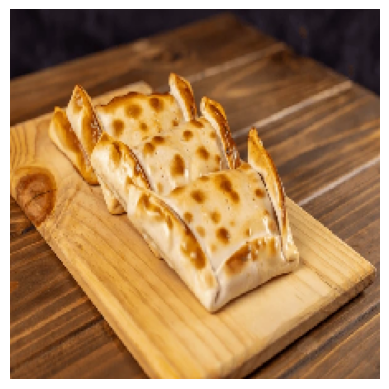

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Top-3 predicciones:
    1. burrito (21.70%)
    2. tray (12.35%)
    3. bakery (7.39%)
Imagen: Gato1 (1).jpeg


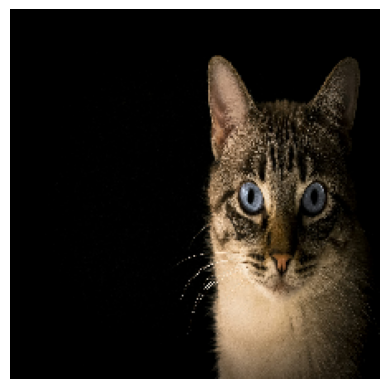

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Top-3 predicciones:
    1. tabby (65.96%)
    2. tiger_cat (21.55%)
    3. Egyptian_cat (2.78%)
Imagen: Gato2 (1).jpeg


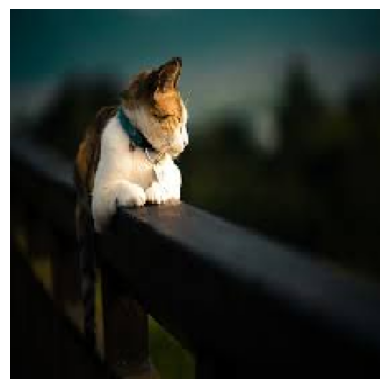

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Top-3 predicciones:
    1. tiger (10.17%)
    2. collie (8.17%)
    3. lion (5.99%)
Imagen: Gato3 (1).jpg


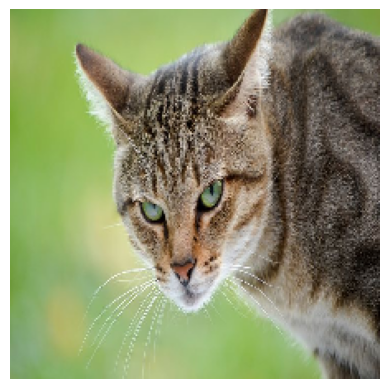

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Top-3 predicciones:
    1. tiger_cat (83.97%)
    2. tabby (6.45%)
    3. Egyptian_cat (3.24%)
Imagen: MoteConHuesillo.jpeg


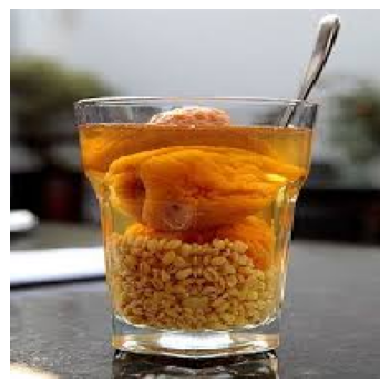

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Top-3 predicciones:
    1. beer_glass (15.43%)
    2. espresso (12.33%)
    3. beaker (10.23%)
Imagen: perro1 (1).webp


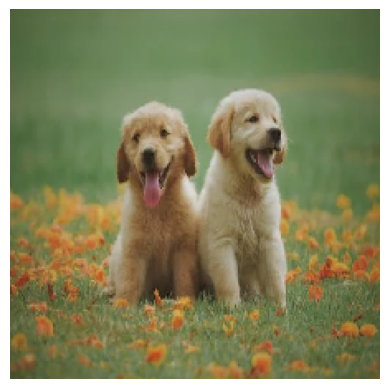

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Top-3 predicciones:
    1. standard_poodle (37.97%)
    2. golden_retriever (26.35%)
    3. Labrador_retriever (6.13%)
Imagen: perro2 (1).jpg


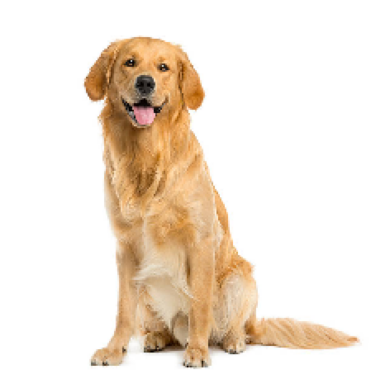

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Top-3 predicciones:
    1. golden_retriever (92.60%)
    2. Labrador_retriever (1.18%)
    3. Brittany_spaniel (0.30%)
Imagen: perro3 (1).jpg


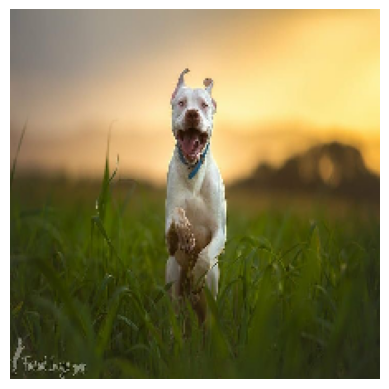

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Top-3 predicciones:
    1. whippet (80.77%)
    2. Great_Dane (4.36%)
    3. American_Staffordshire_terrier (3.28%)
Imagen: Persona-Hombre1.jpg


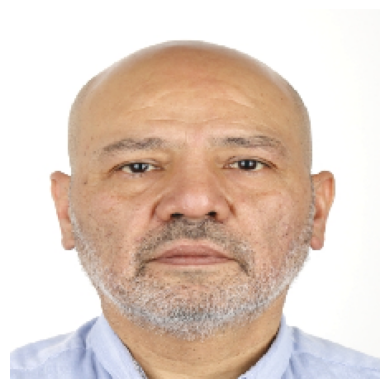

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Top-3 predicciones:
    1. lab_coat (42.71%)
    2. bow_tie (9.44%)
    3. Windsor_tie (4.64%)
Imagen: Persona-Hombre2.jpg


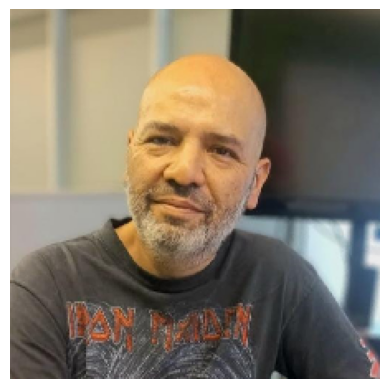

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Top-3 predicciones:
    1. jersey (26.58%)
    2. barbershop (7.14%)
    3. ballplayer (3.03%)


In [ ]:
# PASO 5 Clasificar imágenes y mostrar predicciones
# Clasificar cada imagen y mostrar el top-3 de predicciones
resultados = []  # aquí guardaremos resultados para el análisis posterior

for nombre in nombres_imagenes:
    print("=" * 80)
    print(f"Imagen: {nombre}")

    # Guardar archivo subido en disco temporal
    with open(nombre, "wb") as f:
        f.write(archivos_subidos[nombre])

    # Preparar imagen
    img_original, img_preparada = preparar_imagen(nombre)

    # Mostrar imagen
    plt.imshow(img_original)
    plt.axis("off")
    plt.show()

    # Realizar predicción
    preds = modelo.predict(img_preparada)
    top3 = decode_predictions(preds, top=3)[0]

    print("Top-3 predicciones:")
    predicciones_legibles = []
    for i, (id_clase, etiqueta, prob) in enumerate(top3, start=1):
        texto = f"{i}. {etiqueta} ({prob:.2%})"
        print("   ", texto)
        predicciones_legibles.append(texto)

    # Guardar resultado para análisis posterior
    resultados.append({
        "nombre_archivo": nombre,
        "predicciones": predicciones_legibles,
    })

In [ ]:
# PASO 6 Resumen rápido de resultados
# Resumen general de las imágenes clasificadas
print("RESUMEN DE PREDICCIONES")
print("-" * 80)

for r in resultados:
    print(f"Imagen: {r['nombre_archivo']}")
    for linea in r["predicciones"]:
        print("   ", linea)
    print("-" * 80)

RESUMEN DE PREDICCIONES
--------------------------------------------------------------------------------
Imagen: Empanada1.webp
    1. burrito (21.70%)
    2. tray (12.35%)
    3. bakery (7.39%)
--------------------------------------------------------------------------------
Imagen: Gato1 (1).jpeg
    1. tabby (65.96%)
    2. tiger_cat (21.55%)
    3. Egyptian_cat (2.78%)
--------------------------------------------------------------------------------
Imagen: Gato2 (1).jpeg
    1. tiger (10.17%)
    2. collie (8.17%)
    3. lion (5.99%)
--------------------------------------------------------------------------------
Imagen: Gato3 (1).jpg
    1. tiger_cat (83.97%)
    2. tabby (6.45%)
    3. Egyptian_cat (3.24%)
--------------------------------------------------------------------------------
Imagen: MoteConHuesillo.jpeg
    1. beer_glass (15.43%)
    2. espresso (12.33%)
    3. beaker (10.23%)
--------------------------------------------------------------------------------
Imagen: perro

## Análisis crítico: aciertos, errores y posibles sesgos

1. **Selecciona 1 o 2 imágenes donde el modelo haya fallado**  
   - ¿Qué mostró la imagen realmente?  
   - ¿Qué predijo MobileNetV2?  

2. **Piensa por qué pudo cometer ese error:**
   - ¿La imagen tenía ángulos extraños, poca luz, mucha textura, ruido?  
   - ¿El objeto es poco común o muy específico de tu contexto?  
   - ¿Puede haber diferencias culturales (por ejemplo, tipos de alimentos, objetos locales)?  

3. **Conecta con los tipos de sesgos vistos en la PPT:**
   - ¿Dataset Bias? ¿Measurement Bias? ¿Sampling Bias? ¿Algorithmic Bias?  
   - ¿Qué tipo de sesgo podría estar influyendo en el error?

4. **Reflexiona sobre el uso responsable de estos modelos:**
   - ¿Confiarías en este modelo para una decisión importante?  
   - ¿Qué supervisión humana sería necesaria?  

> **Recuerda:** *Un modelo puede ser muy preciso en promedio, pero profundamente injusto en casos específicos.*  
> Por eso, en esta práctica buscamos analizar **no solo aciertos, sino también posibles errores y sesgos**.


## ⏱️ Reflexión Final

Escribe aquí una reflexión breve (6–10 líneas) sobre:

- Un ejemplo de acierto o error interesante del modelo.
- Qué tipo de sesgo podría estar presente (si aplica).
- Qué implicancias tendría usar este tipo de modelos en educación, salud u otros contextos.
- Qué buenas prácticas crees que son necesarias para usar IA de forma ética y responsable.